# Diabetes Risk Prediction and Biomarker Clustering Analysis Report

### Author: Dong Liang

The project is built based on the dataset derived from a public health study that collected inforation from physical exams, blood tests of participants that were followed up for years with disease outcomes.

- The goals of this project are threefold:
    - to identify Which clinical features and which blood biomarkers are associated with incident diabetes
    - to build a machine learning predictive model based on blood biomarkers for assessing incident diabete risk
    - to identify subests of subjects who developed incident diabetes based on blood biomarkers
- Dataset:
    - diabetes_project_dataset.csv



In [9]:
# Data processing and machine learning
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, SelectFwe, chi2, SelectFdr
from sklearn.ensemble import RandomForestClassifier


# io
import warnings
import re
from time import time
from datetime import datetime
from scipy import stats
import json
import os

# Plotting
import seaborn as sns
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'


## Data Loading

In [ ]:
import time
start = time.time()
chunk = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/diabetes_proj/diabetes1000.csv',low_memory=False, iterator=True, chunksize=100000)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")
diabetes = pd.concat(chunk)

Read csv with chunks:  0.11435270309448242 sec


### Remove subjects with existing diabetes

In [ ]:
incident0 = diabetes.loc[diabetes.existing_diabetes == 0, :]

## Exploratory data analysis

### Summary of the incident dataset

In [ ]:
incident0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7697 entries, 1 to 8290
Columns: 60207 entries, SampleID to mtb_2129684
dtypes: float64(60203), int64(4)
memory usage: 3.5 GB


### Missing data

In [ ]:
def missing_data(ds):
    total = ds.isnull().sum().sort_values(ascending=False)
    percent = (
        (ds.isnull().sum() / ds.isnull().count() * 100)
        .sort_values(ascending=False)
        .round(2)
    )
    data = pd.concat([total, percent], axis=1, keys=["Count", "Percent"])
    return data


mds = missing_data(incident0)
missing_rate = round(100 * (mds[mds.Percent < 20].shape[0]) / incident0.shape[1], 2)
print(f'We have {missing_rate} % columns that have missing data < 20%')

We have 30.1 % columns that have missing data < 20%


Since the missing values for blood biomarkers are usually due to the extremely low abundance of that biomarker in blood samples which could be below the detection limit, we will fill NAs in the blood biomarker data with zeros in the data preprocessing.

### Distributions of randomly selected mtb data

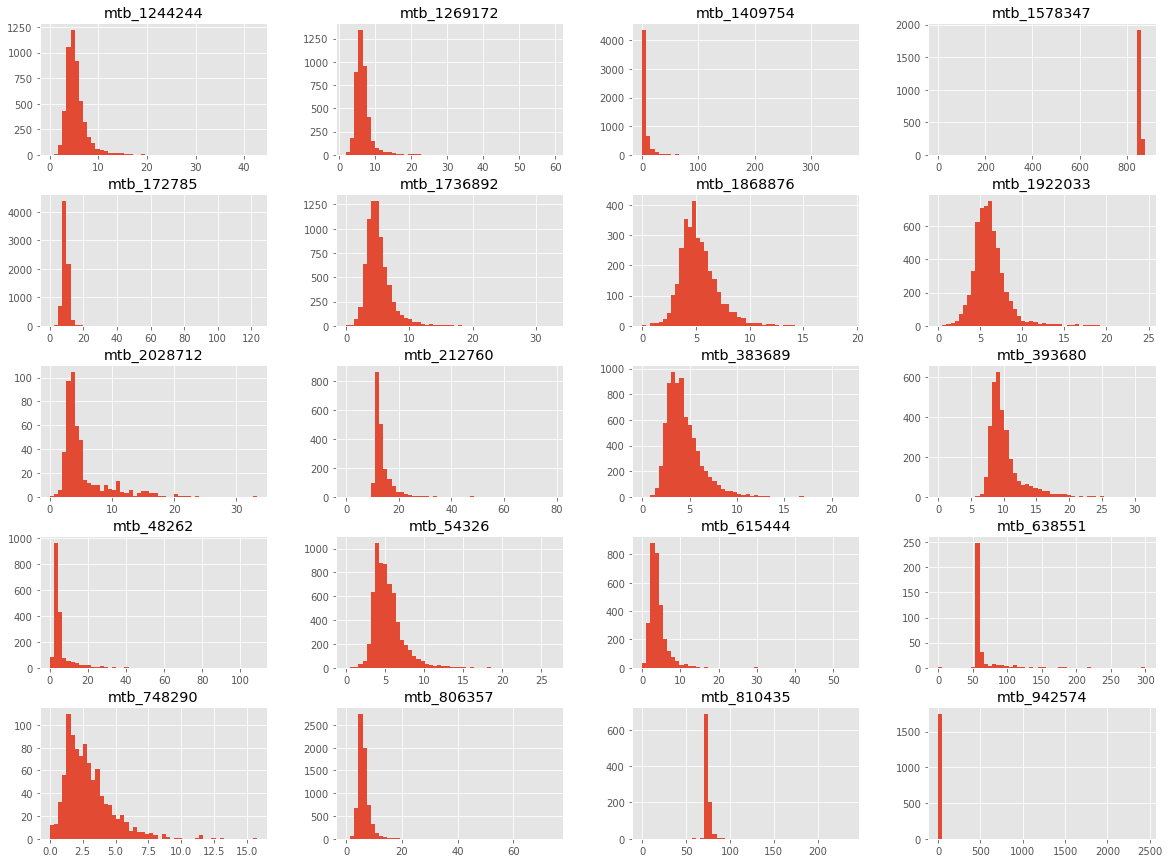

In [ ]:
mtb = incident0.columns[incident0.columns.str.startswith('mtb')]
np.random.seed(3)
mtb_random= np.random.choice(mtb, 20)
_ = incident0.loc[:, mtb_random].hist(bins=50, figsize=(20,15))

Not all the mtb data are normally distributed. Some of the distriubtions are severely right-skewed with significant outliers (e.g. mtb_942574), which justifies the use of log-transformation for data preprocessing. Besides, it could also be better to use median for imputation later on if necessary.

### Distributions of clincial data

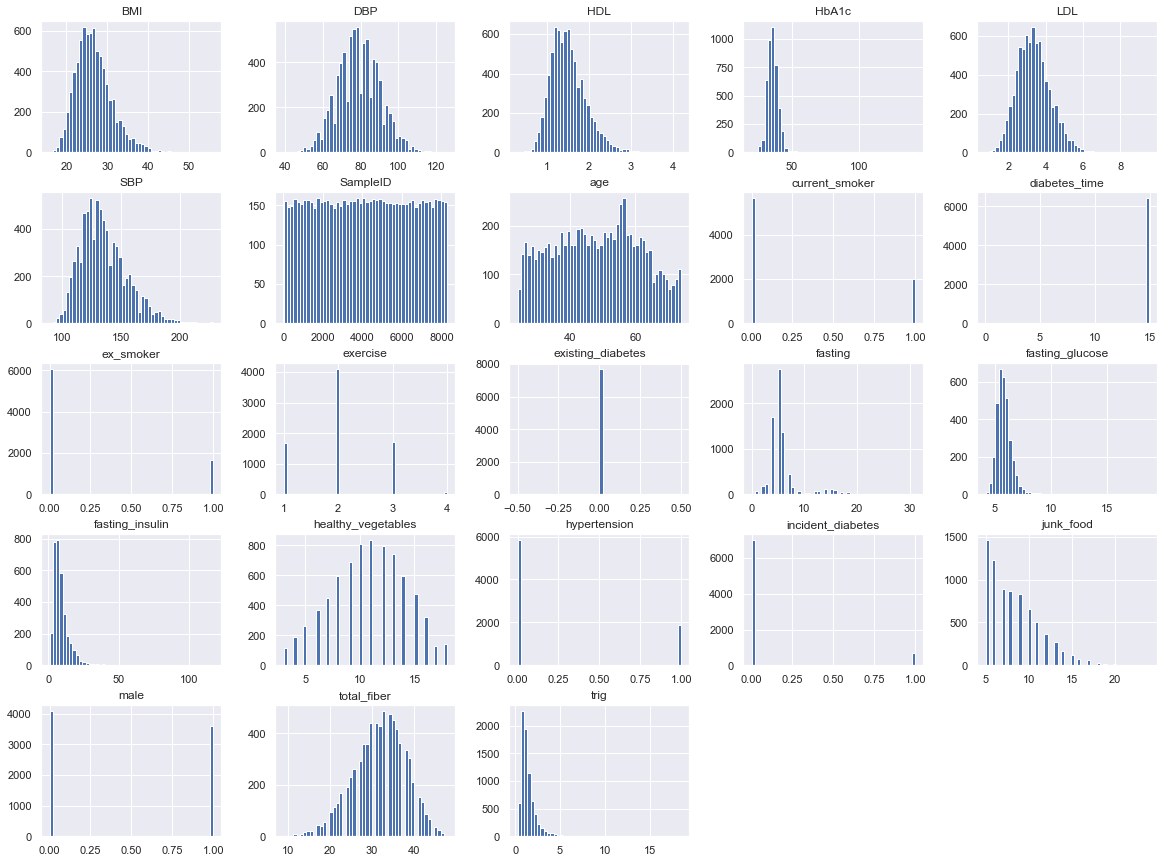

In [ ]:
_ = incident0.loc[:, clinical].hist(bins=50, figsize=(20,15))

### Multicollinearity

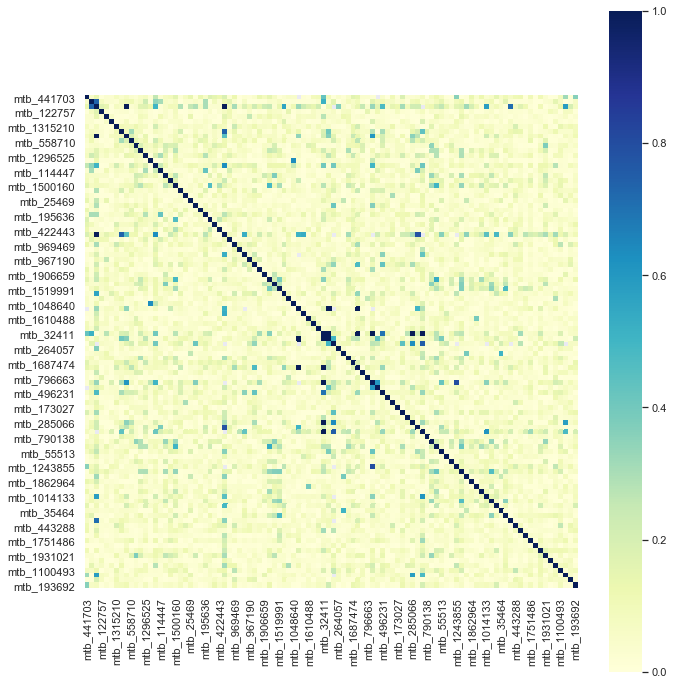

In [ ]:
# Make correlation matrix
corr_matrix = incident0.loc[:, np.random.choice(mtb, 100)].corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 1)

# Set the figure size
f, ax = plt.subplots(figsize=(10, 10))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

It can be seen that our mtb dataset contains redundant features that are high correlated. We may want to remove those collinear features in data processing step.

### Participant age

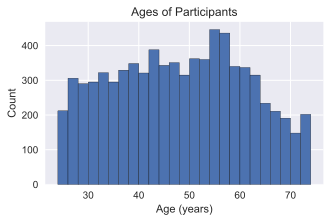

In [ ]:
plt.style.use('seaborn')
plt.hist(incident0['age'], edgecolor = 'k', bins = 25)
plt.title('Ages of Participants')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.gcf().set_size_inches(5, 3)

In [ ]:
incident0['age'].describe()

count    7697.000000
mean       47.598285
std        13.137743
min        24.000000
25%        37.000000
50%        48.000000
75%        58.000000
max        74.000000
Name: age, dtype: float64

### Exercise

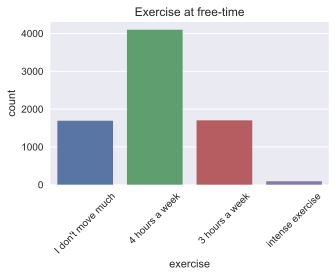

In [ ]:
plt.style.use('seaborn')
sns.countplot(x='exercise', data=incident0)
plt.title('Exercise at free-time')
positions = (0, 1, 2, 3)
labels = ("I don't move much", "4 hours a week", "3 hours a week", "intense exercise")
_ = plt.xticks(positions, labels, rotation=45)
plt.gcf().set_size_inches(5, 3)

### Distribution of the target column (`incident_diabetes`)

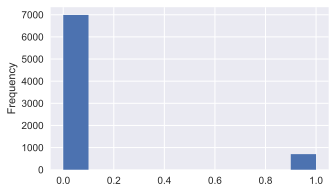

In [ ]:
_ = incident0['incident_diabetes'].astype(int).plot.hist()
plt.gcf().set_size_inches(5, 3)

The data is zero-inflated! This justifies the use of ROCAUC for model evaluation.

### Correlation with the target column (`incident_diabetes`)

Let's compute the spearman correlation coefficient between clinical features and incident diabetes.

In [ ]:
mtb = incident0.columns[incident0.columns.str.startswith('mtb')]
clinical_data = incident0.loc[:, ~incident0.columns.isin(mtb)]

In [ ]:
correlations = clinical_data.corr(method = 'spearman')['incident_diabetes'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(10).sort_values(ascending = False))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 incident_diabetes    1.000000
fasting_glucose      0.343643
fasting_insulin      0.273266
HbA1c                0.270941
BMI                  0.270936
hypertension         0.252546
trig                 0.206510
SBP                  0.150595
DBP                  0.147629
existing_diabetes         NaN
Name: incident_diabetes, dtype: float64

Most Negative Correlations:
 diabetes_time        -0.461070
HDL                  -0.149243
exercise             -0.093437
junk_food            -0.053529
healthy_vegetables   -0.006468
total_fiber          -0.000814
current_smoker        0.009934
SampleID              0.018176
fasting               0.035458
ex_smoker             0.055144
Name: incident_diabetes, dtype: float64


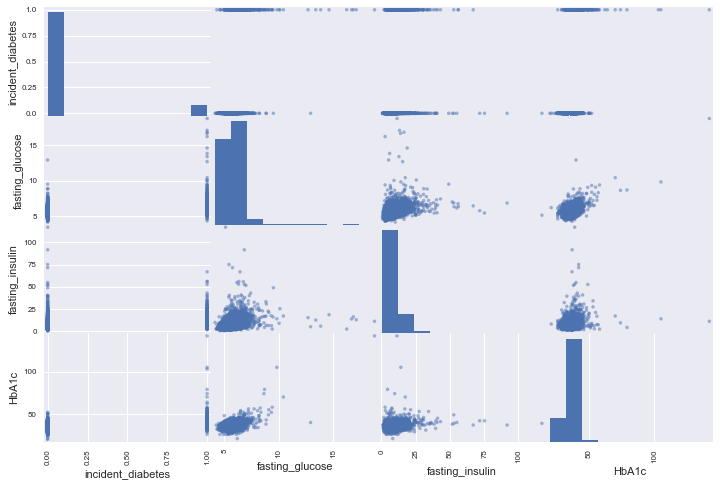

In [ ]:
from pandas.plotting import scatter_matrix

# Top three positively correlated inputs with incident_diabetes
attributes = ["incident_diabetes", "fasting_glucose", "fasting_insulin", "HbA1c"]
scatter_matrix(clinical_data[attributes], figsize=(12, 8))
plt.show()

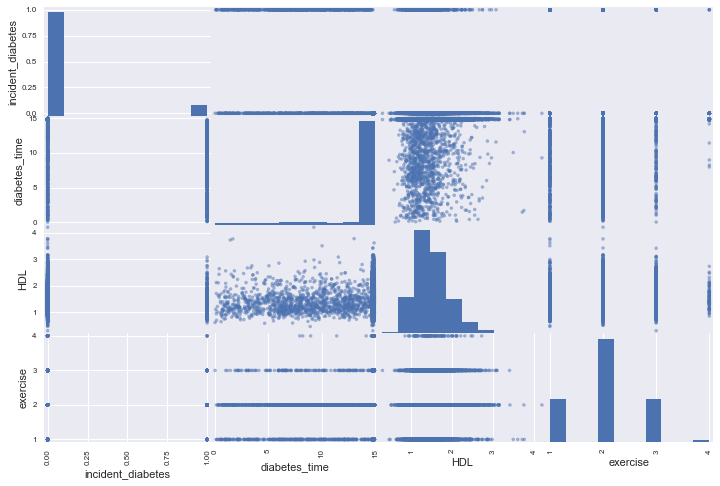

In [ ]:
# Top three inversely correlated numerical inputs with incident_diabetes
attributes = ["incident_diabetes","diabetes_time", "HDL", "exercise"]
scatter_matrix(clinical_data[attributes], figsize=(12, 8))
plt.show()

In [ ]:
# Correlation matrix
clinical_data[
    ["incident_diabetes", "fasting_glucose", "fasting_insulin", "HbA1c", "diabetes_time", "HDL", "exercise"]
].corr().style.background_gradient(cmap = 'PuBu')

,incident_diabetes,fasting_glucose,fasting_insulin,HbA1c,diabetes_time,HDL,exercise
incident_diabetes,1.000000,0.392900,0.265887,0.333870,-0.618267,-0.134273,-0.092766
fasting_glucose,0.392900,1.000000,0.285922,0.542623,-0.416038,-0.184406,-0.080681
fasting_insulin,0.265887,0.285922,1.000000,0.171155,-0.237709,-0.247026,-0.159712
HbA1c,0.333870,0.542623,0.171155,1.000000,-0.355686,-0.071791,-0.080392
diabetes_time,-0.618267,-0.416038,-0.237709,-0.355686,1.000000,0.107416,0.118491
HDL,-0.134273,-0.184406,-0.247026,-0.071791,0.107416,1.000000,0.066560
exercise,-0.092766,-0.080681,-0.159712,-0.080392,0.118491,0.066560,1.000000


## Question 1: Which clinical features and which blood biomarkers are associated with incident diabetes? These clinical features and biomarkers can potentially be risk or protective factors for diabetes development.

To investigate the clinical features and biomarkers that can potentially be risk or protective factors for diabetes development. We will fit logistic regression models for each individual features and biomarkers. The P-values are shown as follows:

In [ ]:
import statsmodels.api as sm

def logistic_regression(df, y, x):
    res = []
    for xx in x:
        model = sm.Logit(df.loc[:, y], sm.add_constant(df.loc[:, xx].fillna(df.loc[:, xx].median())))
        result = model.fit(disp=0)
        s = result.summary2()
        res.append(s.tables[1])

    return pd.concat(res, axis = 0).drop('const').sort_values('P>|z|', ascending = True)



### Clinical features

In [ ]:

clinical_features = [
       'age', 'male', 'BMI', 'HDL', 'LDL', 'trig', 'SBP', 'DBP',
       'hypertension', 'fasting', 'fasting_glucose', 'fasting_insulin',
       'HbA1c', 'current_smoker', 'ex_smoker', 'exercise',
       'healthy_vegetables', 'junk_food', 'total_fiber']


pvalues_clincial = logistic_regression(incident0, 'incident_diabetes', clinical_features)
pvalues_clincial


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
BMI,0.191044,0.008301,23.013304,3.430272e-117,0.174773,0.207315
fasting_glucose,1.706919,0.083224,20.509942,1.755050e-93,1.543803,1.870035
hypertension,1.673550,0.081917,20.429741,9.098297e-93,1.512995,1.834105
HbA1c,0.255288,0.013402,19.049113,6.682492e-81,0.229021,0.281554
fasting_insulin,0.110236,0.007695,14.325398,1.518548e-46,0.095154,0.125318
DBP,0.046680,0.003522,13.254597,4.243878e-40,0.039777,0.053582
trig,0.449359,0.034163,13.153510,1.624547e-39,0.382401,0.516316
SBP,0.023701,0.001810,13.094460,3.541842e-39,0.020153,0.027248
age,0.038789,0.003191,12.155438,5.367314e-34,0.032535,0.045043
HDL,-1.355430,0.115794,-11.705562,1.193662e-31,-1.582381,-1.128478


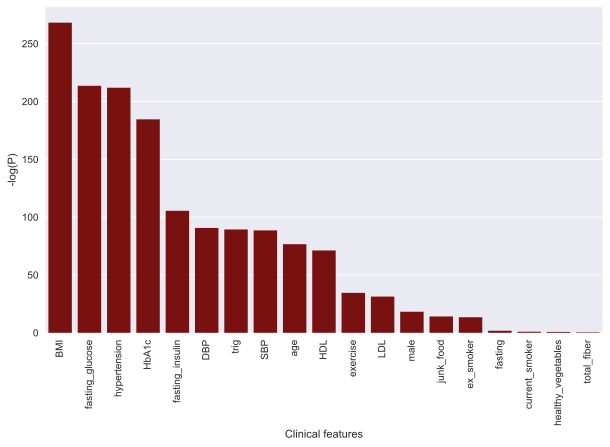

In [ ]:
plt.style.use('seaborn')
pvalues_clincial.reset_index(inplace = True)
pvalues_clincial['-log(P)'] = -np.log(pvalues_clincial['P>|z|'])


plt.figure(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=pvalues_clincial["index"], y=pvalues_clincial["-log(P)"], color='darkred') # ,  color=color
plt.xlabel('Clinical features')
plt.xticks(rotation='vertical')
plt.show()

Based on the p-values for clincial features in logistric regressions, we can find the top 3 most associated risk factors for incident diabete are `BMI`, `fasting_glucose` and `hypertension`.

### For blood biomarkers

In skewed data, outliers in the tail region can adversely affect the performance of the model, especially in regression-based models. If skewness is less than -1 or greater than 1, the distribution is highly skewed. Therefore, we log-transformed each biomarker feature with absolute skewness values greater than 1.




In [ ]:
# Replace all the zeros with small numbers, 1e-10
mtb = incident0.columns[incident0.columns.str.startswith('mtb')]
mtb_df = incident0.loc[:, mtb]
mtb_df.replace({0: 1e-10}, inplace = True)

# Cacluate skewness for each biomarker feature
skewness = mtb_df.skew(axis = 0, skipna = True)

# Fill na with small numbers for those blood biomarkers that have missing values
mtb_df.fillna(1e-10, inplace = True)

# Let's do a log transformation for each biomarker with absolute skewness > 1
mtb_df_log = np.log(mtb_df.loc[:, mtb[abs(skewness) > 1]])

# Modify the biomarker feature names
mtb_df_log.columns = [m + '_log' for m in mtb_df_log.columns]

# Combine
biomarker_log = pd.concat([mtb_df.loc[:, mtb[abs(skewness) <= 1]], mtb_df_log , incident0.loc[:, 'incident_diabetes']], axis=1)

In [ ]:
pvalues_biomarker = logistic_regression(biomarker_log, 'incident_diabetes', mtb_df_log.columns.tolist())
pvalues_biomarker

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
mtb_744362_log,1.286939e+00,0.075449,17.057072,3.096923e-65,1.139062,1.434817
mtb_744357_log,1.350226e+00,0.079322,17.022171,5.624608e-65,1.194758,1.505693
mtb_767346_log,1.209526e+00,0.075046,16.117035,1.936821e-58,1.062437,1.356614
mtb_261033_log,2.166758e+00,0.134676,16.088682,3.062882e-58,1.902798,2.430717
mtb_261031_log,1.955895e+00,0.122861,15.919611,4.632470e-57,1.715093,2.196698
...,...,...,...,...,...,...
mtb_50836_log,9.713238e-07,0.003240,0.000300,9.997608e-01,-0.006350,0.006352
mtb_85566_log,-2.972575e-06,0.014668,-0.000203,9.998383e-01,-0.028752,0.028746
mtb_125182_log,-4.235808e-07,0.003640,-0.000116,9.999072e-01,-0.007135,0.007134
mtb_1156991_log,-3.066181e-07,0.003460,-0.000089,9.999293e-01,-0.006783,0.006782


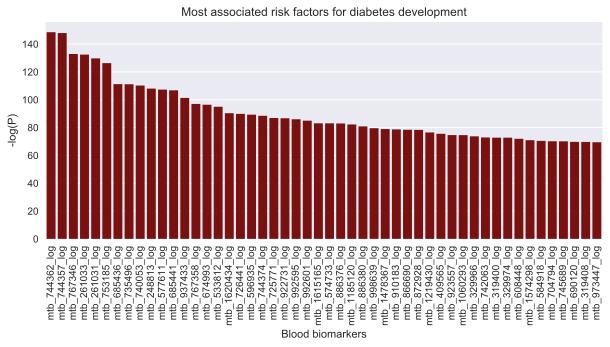

In [ ]:
pvalues_biomarker.reset_index(inplace = True)
pvalues_biomarker['-log(P)'] = -np.log(pvalues_biomarker['P>|z|'])

plt.figure(figsize=(10, 4))
sns.set_color_codes("pastel")
sns.barplot(x="index", y="-log(P)", data=pvalues_biomarker.loc[pvalues_biomarker['Coef.'] > 0, :].iloc[:50, :],  color="darkred" )
plt.xlabel('Blood biomarkers')
plt.xticks(rotation='vertical')
plt.title('Most associated risk factors for diabetes development')
plt.show()

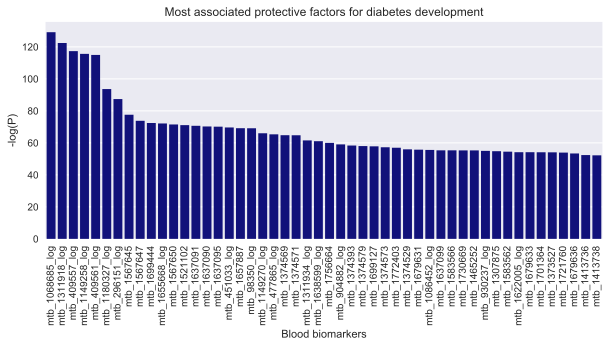

In [ ]:
plt.figure(figsize=(10, 4))
sns.set_color_codes("pastel")
sns.barplot(x="index", y="-log(P)", data=pvalues_biomarker.loc[pvalues_biomarker['Coef.'] < 0, :].iloc[:50, :],  color="darkblue" )
plt.xlabel('Blood biomarkers')
plt.xticks(rotation='vertical')
plt.title('Most associated protective factors for diabetes development')
plt.show()

As we can see `mtb_744362_log` , for example, has the lowest p values (3.096923e-65) with a positive coefficient of 1.28, which means given one unit change in the log(mtb_744362), we can expect the expected log odds of incident_diabetes will change by 1.28 (or the odds ratio of a participant devolopping versus not devolopping an incident diabete is  $e^{1.28}$, or 3.6), according to this univariate logistic regression model.

## Question 2: How can we use blood biomarkers alone to predict the risk of developing diabetes?

We will create classifers based on relavent blood biomarkers with significant p values (< 0.05) to predict the risk of developing incident diabetes.

### Metric functions

In [ ]:
def get_metrics(label, prob):

    prob_pos = prob[label == 1]
    prob_neg = prob[label == 0]

    TP = np.sum(np.array(prob_pos) >= 0.5)
    FN = np.sum(np.array(prob_pos) < 0.5)
    FP = np.sum(np.array(prob_neg) > 0.5)
    TN = np.sum(np.array(prob_neg) <= 0.5)

    # Metrics
    recall = TP / (TP + FN)
    specificity = TN / (TN + FN)
    precision = TP / (TP + FP)
    neg_pred_val = TN / (TN + FP)
    f1 = 2 * (precision * recall) / (precision + recall)
    acc = (TP + TN) / (len(prob_pos) + len(prob_neg))

    # AUC
    auc = roc_auc_score(
        [1] * len(prob_pos) + [0] * len(prob_neg), list(prob_pos) + list(prob_neg)
    )

    return (
        round(auc, 4),
        round(acc, 4),
        round(f1, 4),
        round(recall, 4),
        round(specificity, 4),
        round(precision, 4),
        round(neg_pred_val, 4),

    )

In [ ]:
expLog = pd.DataFrame(columns=["exp_name",
                                       "Test AUC",
                                       "Test Acc",
                                       "Test f1",
                                       "Test Recall",
                                       "Test Specificity",
                                       "Test Precision",
                                       "Test Neg Pred Value"
                                      ])

def model_evaluation(exp_name, model, X_test, expLog):
    try:
        expLog
    except NameError:
        expLog = pd.DataFrame(columns=["Exp Name",
                                       "Test AUC",
                                       "Test Acc",
                                       "Test f1",
                                       "Test Recall",
                                       "Test Specificity",
                                       "Test Precision",
                                       "Test Neg Pred Value"
                                      ])

    metrics = get_metrics(y_test, model.predict_proba(X_test)[:, 1])

    expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
                   [*metrics], 4))
    return expLog


### Create a holdout test set

In [ ]:
# Selected biomarkers with significant p values (< 0.05)
biomarkers_sig = pvalues_biomarker.loc[pvalues_biomarker['P>|z|'] < 0.05, :]['index']

# Split the dataset into training and test sets
X_train = biomarker_log.loc[:, biomarkers_sig]
y_train = biomarker_log['incident_diabetes']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42, stratify = y_train)

print(f"X train           shape: {X_train.shape}")
print(f"X test            shape: {X_test.shape}")

X train           shape: (5387, 15944)
X test            shape: (2310, 15944)


In [ ]:
# Full biomarkers without transformation
biomarkers = incident0.loc[:, mtb]
# Split the dataset into training and test sets
X_train0 = biomarkers.loc[:, mtb]
X_train0.fillna(0, inplace = True)
y_train0 = biomarker_log['incident_diabetes']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_train0, y_train0, test_size=0.30, random_state=42, stratify = y_train0)

print(f"X train           shape: {X_train0.shape}")
print(f"X test            shape: {X_test0.shape}")

X train           shape: (5387, 60184)
X test            shape: (2310, 60184)


### Logistic regression model

We will first build a logistic regression model using features after being preprocessed through the pipeline.

#### Processing pipeline

In [ ]:
# Numerical pipeline
num_pipeline = Pipeline(
    [
#         ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ])

data_prep_pipeline = FeatureUnion(
    transformer_list=[
        ("num_pipeline", num_pipeline)
    ]
)

In [ ]:
def get_processing_pipeline(imputer_strategy = None, std_scaler = True):

    pipeline = []
    if imputer_strategy is not None:
        pipeline.append(("imputer", SimpleImputer(strategy=imputer_strategy)))

    if std_scaler:
        pipeline.append(("std_scaler", StandardScaler()))

    num_pipeline = Pipeline(pipeline)

    data_prep_pipeline = FeatureUnion(
        transformer_list=[
            ("num_pipeline", num_pipeline)
        ]
    )
    return data_prep_pipeline

#### Model with feature engineering and PCA  

In [ ]:
np.random.seed(42)
from sklearn.decomposition import PCA
data_prep_pipeline = get_processing_pipeline(imputer_strategy = None)

# data_prep_pipeline = get_processing_pipeline(imputer_strategy = 'median')
full_pipeline_with_predictor = Pipeline([
        ("preparation", data_prep_pipeline),
        ("feature_selector", SelectKBest(score_func=f_classif, k=25)),  # 15000/0.001, 200/0.001 , 500/0.001, 1000 2000/0.001 10000/(0.001)0.00005
        ("polynomial", PolynomialFeatures(degree=2)),
        ('PCA', PCA(n_components=150, )),
        ("polynomial", PolynomialFeatures(degree=3)),
        ("classifier", LogisticRegression(n_jobs = 1, penalty = 'l2', C = 0.0005))
    ])
logistic_feature_poly = full_pipeline_with_predictor.fit(X_train, y_train)

,exp_name,Test AUC,Test Acc,Test f1,Test Recall,Test Specificity,Test Precision,Test Neg Pred Value
0,lr_grid3,0.7828,0.9074,0.1008,0.0569,0.9128,0.4444,0.9929
1,lr_feature_poly_pca,0.7609,0.9004,0.1288,0.0806,0.9140,0.3208,0.9828
2,lr_feature_poly_pca,0.7828,0.9074,0.1008,0.0569,0.9128,0.4444,0.9929
3,lr_feature_poly_pca,0.7830,0.9078,0.0936,0.0521,0.9125,0.4583,0.9938
4,lr_feature_poly_pca,0.7816,0.9074,0.0776,0.0427,0.9118,0.4286,0.9943
5,lr_feature_poly_pca,0.7794,0.9078,0.0936,0.0521,0.9125,0.4583,0.9938
6,lr_feature_poly_pca,0.7823,0.9087,0.0944,0.0521,0.9126,0.5000,0.9948
7,lr_feature_poly_pca,0.7829,0.9078,0.1013,0.0569,0.9129,0.4615,0.9933
8,lr_feature_poly_pca,0.7827,0.9078,0.1013,0.0569,0.9129,0.4615,0.9933
9,lr_feature_poly_pca,0.7861,0.9074,0.1008,0.0569,0.9128,0.4444,0.9929


In [ ]:
model_evaluation('lr_feature_poly_pca_log', logistic_feature_poly, X_test, expLog)

,exp_name,Test AUC,Test Acc,Test f1,Test Recall,Test Specificity,Test Precision,Test Neg Pred Value
0,lr_featureSelection,0.7765,0.9056,0.1484,0.0900,0.9152,0.4222,0.9876
1,lr_featureSelection,0.7647,0.8840,0.2678,0.2322,0.9248,0.3161,0.9495
2,lr_featureSelection,0.6880,0.8489,0.2296,0.2464,0.9231,0.2149,0.9095
3,lr_feature_poly,0.7504,0.9013,0.1493,0.0948,0.9152,0.3509,0.9824
4,lr_feature_poly,0.7504,0.9013,0.1493,0.0948,0.9152,0.3509,0.9824
5,lr_feature_poly,0.7504,0.9013,0.1493,0.0948,0.9152,0.3509,0.9824
6,lr_feature_poly,0.6495,0.8762,0.2474,0.2227,0.9234,0.2781,0.9419
7,lr_feature_100,0.7690,0.9087,0.2156,0.1374,0.9192,0.5000,0.9862
8,lr_feature_poly_50,0.6791,0.8779,0.2123,0.1801,0.9200,0.2585,0.9481
9,lr_feature_poly_50_log,0.6547,0.8628,0.2249,0.2180,0.9219,0.2323,0.9276


#### Hyperparameter tunining, feature selection and feature engineering using grid search

In [ ]:
data_prep_pipeline = get_processing_pipeline(imputer_strategy = None)

In [ ]:
from time import time
# A Function to execute the grid search and record the results.
def conductGridSearch_lr(
    X_train, y_train, X_test, y_test, feature_selection_method, i=0, prefix=""
):

    i += 1

    if feature_selection_method == 'rf':
        feature_selection = SelectFromModel(RandomForestClassifier(n_jobs=-1, max_depth=10, n_estimators=50),
                                            threshold='20*mean') # , threshold='20*mean'

        params = {
        "feature_selector__threshold": ['mean', '10*mean', '20*mean'], # (5, 10, 15, 25, 35 50, ),
        "classifier__penalty": ("l1", "l2"),
        "classifier__C": (0.01, 0.001, 0.0001, 0.0005), # , 10, 1,  0.1, 0.01
        "polynomial": ('passthrough', PolynomialFeatures(degree=2))
        }

    elif  feature_selection_method == 'KBest':
        feature_selection = SelectKBest(f_classif, k = 18)
        params = {
        "feature_selector__k": (25, 200, 500, 10000, 15000), # (5, 10, 15, 25, 35 50, ),
        "classifier__penalty": ("l1", "l2"),
        "classifier__C": (0.01, 0.001, 0.0001, 0.0005), # , 10, 1,  0.1, 0.01
        "polynomial": ('passthrough', PolynomialFeatures(degree=2))
        }

    else:
        print('method not valid')

    # generate the pipeline
    full_pipeline_with_predictor = Pipeline(
        [
            ("preparation", data_prep_pipeline),
            ("feature_selector", feature_selection),  #SelectKBest(score_func=f_classif, k=25)),
            ("polynomial", PolynomialFeatures(degree=2)),
            ("classifier", LogisticRegression(n_jobs = 1, random_state=42)),
        ]
    )



    grid_search = GridSearchCV(
        full_pipeline_with_predictor,
        params,
        scoring="roc_auc",
        cv=5,
        verbose=1,
        n_jobs=2,
    )
    grid_search.fit(X_train, y_train)

    # Best estimator score
    best_train_score = np.round(grid_search.best_score_, 4)

    # Best estimator fitting time
    start = time()
    grid_search.best_estimator_.fit(X_train, y_train)
    train_time = round(time() - start, 4)

    # Best estimator prediction time
    start = time()
    best_test_score = np.round(grid_search.best_estimator_.score(X_test, y_test), 4)
    test_time = round(time() - start, 4)

    # Collect the best parameters found by the grid search
    print("Best Parameters:")
    best_parameters = {}
    best_parameters["k"] = grid_search.best_estimator_.get_params()[
        "feature_selector__k" if feature_selection_method == 'KBest' else "feature_selector__threshold"
    ]
    best_parameters["penalty"] = grid_search.best_estimator_.get_params()[
        "classifier__penalty"
    ]
    best_parameters["C"] = grid_search.best_estimator_.get_params()["classifier__C"]
#     best_parameters["polynomial"] = grid_search.best_estimator_.get_params()["polynomial__degree"]
    param_dump = []
    param_dump.append(best_parameters)
    print("\t" + "best parameters: " + str(best_parameters))
    print("****** FINISH", prefix, " *****")
    print("")



    #set up reporting format
    results = pd.DataFrame(columns=["Classifier", "Cross fold train AUC", "test AUC", "Train Time(s)",
                                "Test Time(s)", "Experiment description"])
    # Record the results
    results.loc[i] = [
        prefix,
        best_train_score,
        best_test_score,
        train_time,
        test_time,
        json.dumps(param_dump),
    ]

    return results, grid_search.best_estimator_, grid_search

In [ ]:
results, logistic_grid_search, search = conductGridSearch_lr(
    X_train, y_train, X_test, y_test, 'KBest', 0, "Logistic Regression ",
)

In [ ]:
results, logistic_grid_search, search = conductGridSearch_lr(
    X_train, y_train, X_test, y_test, 'rf', 0, "Logistic Regression ",
)

In [ ]:
results

,Classifier,Cross fold train AUC,test AUC,Train Time(s),Test Time(s),Experiment description
1,Logistic Regression,0.7869,0.9074,3.7204,0.4367,"[{""k"": 25, ""penalty"": ""l2"", ""C"": 0.01}]"


In [ ]:
results

,Classifier,Cross fold train AUC,test AUC,Train Time(s),Test Time(s),Experiment description
1,Logistic Regression,0.7995,0.91,3.8406,0.4548,"[{""k"": ""10*mean"", ""penalty"": ""l2"", ""C"": 0.001}]"


In [ ]:
results

,Classifier,Cross fold train AUC,test AUC,Train Time(s),Test Time(s),Experiment description
1,Logistic Regression,0.8109,0.9082,4.5096,0.471,"[{""k"": 300, ""penalty"": ""l2"", ""C"": 0.001}]"


In [ ]:
results

,Classifier,Cross fold train AUC,test AUC,Train Time(s),Test Time(s),Experiment description
1,Logistic Regression,0.8103,0.91,4.1008,1.0637,"[{""k"": 500, ""penalty"": ""l2"", ""C"": 0.001}]"


In [ ]:
results

,Classifier,Cross fold train AUC,test AUC,Train Time(s),Test Time(s),Experiment description
1,Logistic Regression,0.7977,0.91,3.6242,0.4255,"[{""k"": 150, ""penalty"": ""l2"", ""C"": 0.001}]"


In [ ]:
model_evaluation('lr_rf_10*mean', logistic_grid_search, X_test, expLog)

,exp_name,Test AUC,Test Acc,Test f1,Test Recall,Test Specificity,Test Precision,Test Neg Pred Value
0,lr_kb_15000,0.8433,0.9104,0.2129,0.1327,0.9190,0.5385,0.9886
1,lr_kb_10000,0.7913,0.9039,0.1838,0.1185,0.9173,0.4098,0.9828
2,lr_kb_200,0.7955,0.9100,0.1333,0.0758,0.9145,0.5517,0.9938
3,lr_kb_500,0.8003,0.9100,0.1545,0.0900,0.9156,0.5429,0.9924
4,lr_kb_25,0.7828,0.9074,0.1008,0.0569,0.9128,0.4444,0.9929
5,lr_rf_10*mean,0.7929,0.9095,0.0711,0.0379,0.9116,0.5714,0.9971
6,lr_rf_10*mean,0.7911,0.9091,0.0187,0.0095,0.9094,0.6667,0.9995


### Summary



In this session, we developed several blood biomarkers-based risk prediction models to predict the risk of developing incident diabetes.  The task involved several major steps.

- imputing missing values
- dectecting multicollinearity
- engineering features
- building pipelines to ensure repeatable processes
- running experiments iteratively
- seeking optimal hyper-parameters for prediction models
- fitting model parameters
- validate models against a holdout test set

Predicting whether a particular participant will develop incident diabetes in the future is a classification task. We have conducted a series of experiments to determine an optimal classification model. Candidate model algorithms include several varieties such as logistic regression as well as random forest.

In this modeling, we explored a series of hyperparameter space and used a variety of modeling techniques. A series of pipelines that encompass various logistic regression with model-based feature selection (SelectKBest-based, randomForests-based) have been created for building predictive classification models.

- Imputing missing values with zeors or median for biomarkers
- Feature engineering: Pipeline ("polynomial", PolynomialFeatures(degree=2)) was used for creating new feature matrix of higher-degree polynomials. Pipeline ('PCA', PCA(n_components=150, )) was used for dimenstionality reduction.
- Feature selection: Pipeline ("feature_selector", SelectKBest(score_func=f_classif, k=25)) was used for selecting k best features based on ANOVA F-value computed by `f_classif`.
- L1/L2 regularization: We used regularization techniques to reduce overfitting
- 10 X cross validation: Cross validation was used for hypyerparameter tunning
- Grid search for exploration of hyperparameter space

![image.png](attachment:17b67e9d-1959-44e2-8efd-07b57512d82e.png)

As summarized in the table above, the optimal logistic regression model (`lr_kb_15000`) achieves the highest Test AUC of 0.8433. This model was trained using several model optimization techniques including feature selection (SelectKBest()) and L2 regularization and regularization penalty. We performed a 10X cross validation to explore the model's hyperparameter space. The optimal model was obtained with the following hyperparameter settings.

```
{'classifier__C': 0.001,
 'classifier__penalty': 'l2',
 'feature_selector__k': 15000,
 'polynomial': 'passthrough'}
```

It's worth noting that if we reduce the number of biomarkers involved in the modeling to 25 (or 200, 500), despite the reduction of the test AUC score to 0.7828 (0.7955, 0.8003), these models have no significant drop in Test Acc, Test Specificity, Test Precision, Test Neg Pred Value metrics. The model using 500 biomarkers (lr_kb_500) even obtained the higher score on Test Precision (0.5429). In addition, the model using randomForest-based feature selection did not score higher than the models using ANOVA F-value-based feature selection on Test AUC. However, the randomForest feature selection-based model obtained the highest score of 0.6667 on the Test Precision metric.
The hyperparameter is shown as follows:

```
{'classifier__C': 0.0005,
 'classifier__penalty': 'l2',
 'feature_selector__threshold': 10*mean,
 'polynomial': 'passthrough'}
```

Overall, although our best model scored 0.84 on the Test AUC, all the models scored low on the Test Recall and Test Precision metrics, and conversely, scored high on the Test Specificity and Test Neg Pred Value, which means that our models are more sensitive to detect negative samples than to positive samples. Due to the time constraint and the computational resource limit (e.g. lack of GPU), this experiment only explored a limited hyperparameter space, and some traditional machine learning algorithm for predictive modeling and evaluation. In order to improve the sensitivity of the model to negative samples, we may want to try building convolutional neural network (CNN, or ConvNet) as an alternative to develop more reliable models in the future.

### Question 3: Are there any clusters based on blood biomarkers among the participants who developed incident diabetes? Can you identify which blood biomarkers defined these clusters?

#### Functions

In [ ]:
import umap
from sklearn import mixture
from sklearn.cluster import KMeans

def plot_umap(X, n_neighbors = 3, min_dist=0.001, random_seed = 96, gmm_cluster_n=3, kmean_cluster_n=3, clusering_method='gmm', streamlit = False):

    np.random.seed(random_seed)
    X_embedded = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist = min_dist,
        n_components = 2,
        metric = 'euclidean'   # braycurtis  euclidean
    ).fit_transform(X)

    if clusering_method == 'gmm':
        # gmm clustering
        gmm = mixture.GaussianMixture(
            n_components=gmm_cluster_n, covariance_type="full", random_state=96).fit(X_embedded)
        labels = gmm.predict(X_embedded)
    elif clusering_method == 'kmean':

        # kmean clustering
        kmeans = KMeans(n_clusters=kmean_cluster_n,
                        random_state=96).fit(X_embedded)
        labels = kmeans.labels_

    # Plot
    labels = pd.Series(labels).replace(
        {0: "I", 1: "II", 2: "III", 3: "IV", 4: "V", 5: "VI", 6: "VII", 7: "VIII"})  # .values

    labels = pd.Categorical(
        labels, categories=np.unique(labels))  # ['I', 'II', 'III', "IV", 'V', 'VI', 'VII', "VIII"])

    fig,ax = plt.subplots()
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],
                    hue=labels, palette='tab10')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.axis('off')

    return labels

In [ ]:
from collections import defaultdict
def get_mean(x):
    sem = np.std(x) / np.sqrt(len(x))
    mean = np.mean(x)
    return f"{round(mean, 2)} ({round(sem, 2)})"


def get_fraction(x):
    record = defaultdict()
    count = 0
    for c in x:
        if c in record:
            record[c] += 1
        else:
            record[c] = 1
        count += 1

    frac = sorted([
        str((k, round(v/count, 2)))
        for k, v in record.items()
    ], reverse=True)# [0]
    return frac

def get_subset_characteristics(subset, columns = ['I', 'II', 'III']):
    get_mean.__name__ = " " # "Mean (SEM)"
    get_fraction.__name__ =" " #  "Fraction"

    res = subset.groupby(["label"]).agg(
        {

            "age": [get_mean],
            'diabetes_time': [get_mean],
            "BMI": [get_mean ],
            "fasting_glucose": [get_mean ],
            "fasting_insulin": [get_mean],
            "HbA1c": [get_mean ],
            "hypertension": [get_mean ],
            "SBP": [get_mean],
            "DBP": [get_mean],
            "trig": [get_mean],
            "HDL": [get_mean],
            "LDL": [get_mean],
            "junk_food": [get_mean],
            "male": [get_fraction],
        }
    ).round(2).T
    # res = res.rename(columns = {'label': 'stat'}, inplace = False)
    res.columns = columns
    return res

#### Unsupervised learning using top 20 most associated biomarkers

We will use top 20 most associated biomarkers to identify subsets of participants who developed incident diabetes

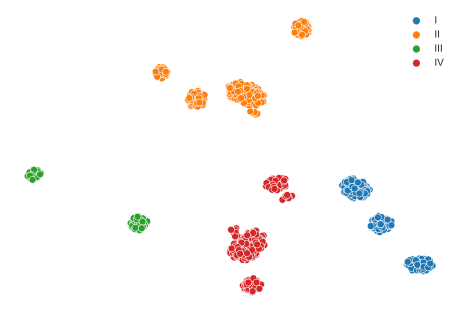

In [ ]:
biomarkers_selected = pvalues_biomarker.loc[pvalues_biomarker['P>|z|'] < 0.05, :]['index'].iloc[:20]
incident_subset_selected = incident_subset.loc[:, biomarkers_selected]

labels = plot_umap(incident_subset_selected, n_neighbors = 1000, min_dist=.99, random_seed = 96, gmm_cluster_n=5, kmean_cluster_n=4, clusering_method='kmean', streamlit = False)

In [ ]:
clinical_subset = incident0.loc[incident0.incident_diabetes == 1, ~incident0.columns.isin(mtb)]
clinical_subset['label'] = labels
get_subset_characteristics(clinical_subset, ['I', 'II', 'III', 'IV'])

,,I,II,III,IV
age,,51.36 (0.82),53.83 (0.71),55.55 (1.21),54.19 (0.69)
diabetes_time,,8.29 (0.27),8.17 (0.24),8.25 (0.44),7.56 (0.27)
BMI,,30.67 (0.37),30.07 (0.32),31.59 (0.58),31.91 (0.35)
fasting_glucose,,6.78 (0.12),6.39 (0.08),6.5 (0.1),7.14 (0.14)
fasting_insulin,,14.77 (0.76),11.95 (0.48),12.35 (0.7),14.94 (0.57)
HbA1c,,39.68 (0.6),39.9 (0.34),42.67 (0.81),42.05 (0.86)
hypertension,,0.58 (0.04),0.54 (0.03),0.59 (0.06),0.63 (0.03)
SBP,,144.93 (1.47),141.13 (1.33),144.73 (2.5),146.95 (1.42)
DBP,,85.36 (0.78),83.25 (0.72),83.33 (1.18),85.48 (0.79)
trig,,2.07 (0.11),1.72 (0.07),1.95 (0.12),2.13 (0.09)


In [ ]:
# Selected biomarkers
biomarkers_selected

0      mtb_744362_log
1      mtb_744357_log
2      mtb_767346_log
3      mtb_261033_log
4      mtb_261031_log
5     mtb_1068685_log
6      mtb_753185_log
7     mtb_1311918_log
8      mtb_409557_log
9     mtb_1149258_log
10     mtb_409561_log
11     mtb_685436_log
12     mtb_735496_log
13     mtb_740053_log
14     mtb_248813_log
15     mtb_577611_log
16     mtb_685441_log
17     mtb_937433_log
18     mtb_767358_log
19     mtb_674993_log
Name: index, dtype: object

#### Summary

In order to gain insights into the potential intrinsic links between participants who developed incident diabetes, we developed a Uniform Manifold Approximation and Projection (UMAP)-based unsupervised learning model to cluster subsets of participants. Specifically, we first constructed a dataset that integrates top 20 most  associated blood biomarkers. We then conducted a grid search to explore the optimal hyperparameter space of UMAP for values of `n_neighbor` (number of neighbors) and `min_dist` (desired separation of the neighboring points in the embedding space) (data not shown). After multiple rounds of experiments, we found that the optimal clustering and algorithm convergence were achieved with n_neighbor = 1000 and min- dist = 0.99, which successfully yielded several meaningful structures for all the participants.


The 4 subsets of participants have the following characteristics:

**Category I**: Participants in the this category have the youngest `age` of 51.36, but the longest `diabetes_time`, lower `BMI` and `hypertension`, higher `trig` and `LDL`, and highest `junk_food`. In addition, it has the highest proportion of males at approximately 68%.

**Category II**: Its `BMI` was relatively low. Both `HbA1c` and `fasting_glucose` are relatively low or lowest, The `SBP` and `DBP` are the lowest amongst all categories. Although both `HDL` and `HDL` are high, `trig` was the lowest. In addition, it has a balanced male to female ratio, with females accounting for approximately 53% of this category.

**Category III**: This category has the highest `age` (55.55) of the 4 categories. It also have the highest `HbA1c`, and most metrics in category III are in the middle of the pack. Females occupy about 59% of this category.

**Category IV**: This category was on the higher end in age among all 4 category (54.19). However, it has the shortest `diabetes_time` of only 7.56. The `BMI`s in participants of category IV are noticeably higher. In addition, it also has the highest `fasting_glucose`, `fasting_insulin`, `hypertension`, `DBP`, `SBP`, `trig`, `LDL`, but a relatively lower `HDL`. Males predominate in this category, accounting for approximately 63%.
